In [92]:
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

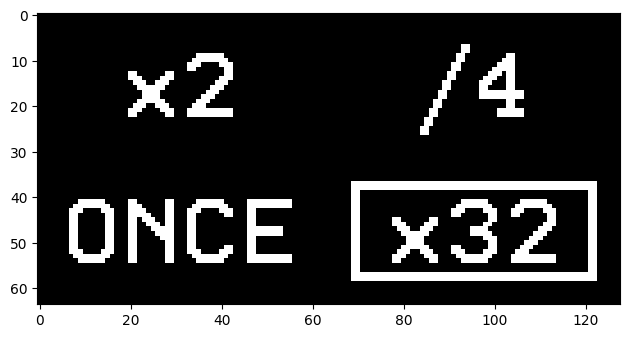

In [93]:
img = ski.io.imread("main_menu.png")[:, :, :3]
img = ski.util.img_as_ubyte(img)
bg_color = [0, 0, 0]
ski.io.imshow(img)
ski.io.show()

In [94]:
img.shape

(64, 128, 3)

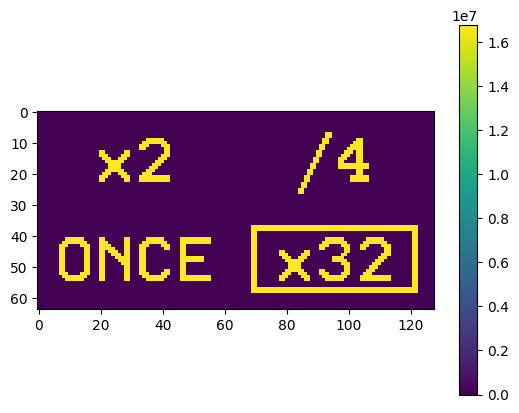

In [95]:
img_rgb = np.left_shift(img[:,:, 0].astype(np.uint32), 16) + np.left_shift(img[:,:, 1].astype(np.uint32), 8) + img[:,:, 2].astype(np.uint32)
bg_color_rgb = np.left_shift(bg_color[0], 16) + np.left_shift(bg_color[1], 8) + bg_color[2]
plt.imshow(img_rgb)
plt.colorbar()
plt.show()

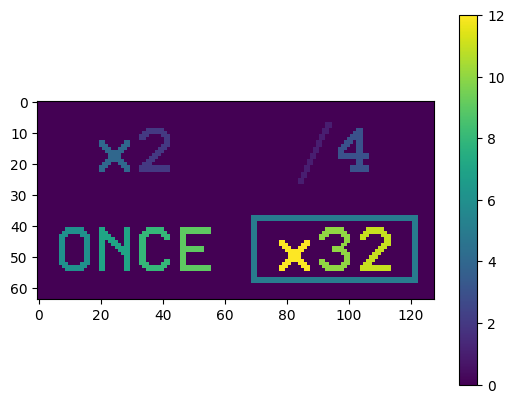

In [96]:
labels, num_labels = ski.measure.label(img_rgb, return_num=True, connectivity=1, background=bg_color_rgb)
plt.imshow(labels)
plt.colorbar()
plt.show()

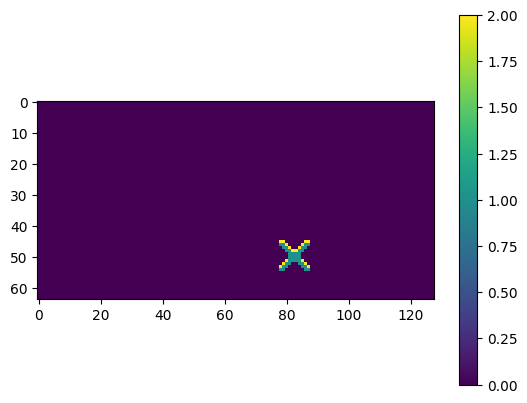

In [97]:
kernel_top = np.flip(np.array(
    [[0, -1, 0],
     [0, 1, 0],
     [0, 0, 0]], dtype=np.int8))
kernel_bottom = np.flip(np.array(
    [[0, 0, 0],
     [0, 1, 0],
     [0, -1, 0]], dtype=np.int8))
kernel_left = np.flip(np.array(
    [[0, 0, 0],
     [-1, 1, 0],
     [0, 0, 0]], dtype=np.int8))
kernel_right = np.flip(np.array(
    [[0, 0, 0],
     [0, 1, -1],
     [0, 0, 0]], dtype=np.int8))

label = num_labels
mask = labels == label
top_edges = ndimage.convolve(mask.astype(np.int8), kernel_top, mode="constant", cval=0) == 1
debug = mask.astype(np.int8)
debug[top_edges] = 2
plt.imshow(debug)
plt.colorbar()
plt.show()

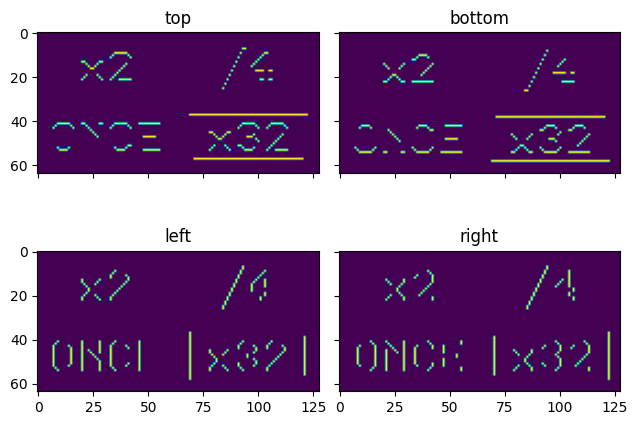

In [98]:
edges = np.zeros((labels.shape[0], labels.shape[1], 4), dtype=bool)
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
for label in range(1, num_labels+1):
    mask = labels == label
    top_edges = ndimage.convolve(mask.astype(np.int8), kernel_top, mode="constant", cval=0) == 1
    bottom_edges = ndimage.convolve(mask.astype(np.int8), kernel_bottom, mode="constant", cval=0) == 1
    left_edges = ndimage.convolve(mask.astype(np.int8), kernel_left, mode="constant", cval=0) == 1
    right_edges = ndimage.convolve(mask.astype(np.int8), kernel_right, mode="constant", cval=0) == 1
    edges[top_edges, UP] = True
    edges[bottom_edges, DOWN] = True
    edges[left_edges, LEFT] = True
    edges[right_edges, RIGHT] = True

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
axs[0, 0].set_title("top")
axs[0, 0].imshow(edges[:, :, UP])
axs[0, 1].set_title("bottom")
axs[0, 1].imshow(edges[:, :, DOWN])
axs[1, 0].set_title("left")
axs[1, 0].imshow(edges[:, :, LEFT])
axs[1, 1].set_title("right")
axs[1, 1].imshow(edges[:, :, RIGHT])
fig.tight_layout()
plt.show()
all_edges = edges

In [99]:
def optimize_seq(seq):
    i = 1
    while i + 1 < len(seq):
        if any(seq[i][xy] == seq[i-1][xy] and seq[i][xy] == seq[i+1][xy] for xy in [0, 1]):
            del seq[i]
        else:
            i += 1
    if seq[0] == seq[-1] and len(seq) > 1:
        return seq[:-1]
    else:
        return seq

optimize_seq([[1,1], [1,2], [1,3], [1, 4], [2, 4], [3, 4], [3, 1], [1, 1]])

[[1, 1], [1, 4], [3, 4], [3, 1]]

In [102]:
def trace_path(edges, label):
    edges = edges.copy()
    path = ""
    mask = np.logical_and(np.any(edges, axis=2), labels==label)
    while np.any(mask):
        # plt.imshow(mask)
        # plt.show()
        edges[~mask] = 0
        indices = np.argwhere(mask)
        start_index = indices[0]
        seq = []
        if edges[*start_index, UP]:
            start_edge = UP
            seq.append(start_index)
        elif edges[*start_index, DOWN]:
            start_edge = DOWN
            seq.append(start_index + [1, 1])
        elif edges[*start_index, RIGHT]:
            start_edge = RIGHT
            seq.append(start_index + [0, 1])
        elif edges[*start_index, LEFT]:
            start_edge = LEFT
            seq.append(start_index + [1, 0])
        
        cursor = (start_index, start_edge)
        
        connections = {
            UP: [
                ([ 1,  0], UP),
                ([ 1, -1], LEFT),
                ([ 0,  0], RIGHT),
            ],
            DOWN: [
                ([-1,  0], DOWN),
                ([-1,  1], RIGHT),
                ([ 0,  0], LEFT),
            ],
            RIGHT: [
                ([ 0,  1], RIGHT),
                ([ 1,  1], UP),
                ([ 0,  0], DOWN),
            ],
            LEFT: [
                ([ 0, -1], LEFT),
                ([-1, -1], DOWN),
                ([ 0,  0], UP),
            ],
        }
        
        while True:
            p, edge = cursor
            edges[*p, edge] = False
            if edge == UP:
                seq.append(p + [0, 1])
            elif edge == DOWN:
                seq.append(p + [1, 0])
            elif edge == LEFT:
                seq.append(p + [0, 0])
            elif edge == RIGHT:
                seq.append(p + [1, 1])
            done = True
            for [dx, dy], new_edge in connections[edge]:
                delta = [dy, dx]
                if edges[*(p + delta), new_edge]:
                    cursor = (p + delta, new_edge)
                    done = False
                    break
            if done:
                break
        
        seq = optimize_seq([tuple(reversed(p)) for p in seq])
        path += f"M {seq[0][0]},{seq[0][1]} "
        path += " ".join(f"L {x},{y}" for x, y in seq[1:])
        path += " z "
        mask = np.logical_and(np.any(edges, axis=2), labels==label)
    return path[:-1]
trace_path(all_edges, 12)

'M 78,45 L 80,45 L 80,46 L 81,46 L 81,47 L 82,47 L 82,48 L 84,48 L 84,47 L 85,47 L 85,46 L 86,46 L 86,45 L 88,45 L 88,47 L 87,47 L 87,48 L 86,48 L 86,49 L 85,49 L 85,51 L 86,51 L 86,52 L 87,52 L 87,53 L 88,53 L 88,55 L 86,55 L 86,54 L 85,54 L 85,53 L 84,53 L 84,52 L 82,52 L 82,53 L 81,53 L 81,54 L 80,54 L 80,55 L 78,55 L 78,53 L 79,53 L 79,52 L 80,52 L 80,51 L 81,51 L 81,49 L 80,49 L 80,48 L 79,48 L 79,47 L 78,47 z'

In [103]:
paths = []
for label in range(1, num_labels+1):
    data = trace_path(all_edges, label)
    color = img[labels == label][0]
    paths.append((color, data))
len(paths)

12

In [104]:
import svgwrite

height, width, _ = img.shape

svg = svgwrite.Drawing('test.svg', profile='tiny')
svg.viewbox(width=width, height=height)
svg.add(svg.rect(size=(width, height), fill=f"rgb({bg_color[0]},{bg_color[1]},{bg_color[2]})"))
for color, data in paths:
    svg.add(svg.path(d=data, fill=f"rgb({color[0]},{color[1]},{color[2]})"))
svg.save()